In [4]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [69]:
#Read the data and drop invalide entries indicated by the value -99.99
co2_df = pd.read_csv('./release_time_series_report_data/CO2.csv', skiprows=57, usecols=[0,1,3,4], names=['Year','Month','Date','CO2'])
co2_df['Period'] = co2_df['Date']-1958
co2_df = co2_df[co2_df['CO2']!=-99.99]


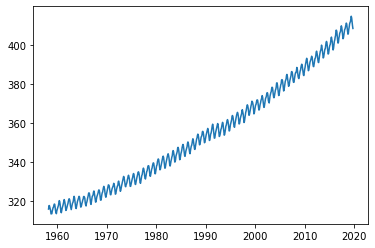

In [6]:
#Plot the data set
plt.plot(co2_df['Date'],co2_df['CO2'])

In [7]:
#Looks like seasonal variation, with increasing trend but not necessarily linear trend (maybe linear after a log tranform)

In [8]:
#Set the training split and get the count of training data points.
train_pct = 0.80
train_count = int(co2_df.shape[0] * train_pct)

#Split the data set into training and test sets
X_train = [[Period] for Period in co2_df['Period'][:train_count]]
Y_train = [[CO2] for CO2 in co2_df['CO2'][:train_count]]
X_test = [[Period] for Period in co2_df['Period'][train_count:]]
Y_test = [[CO2] for CO2 in co2_df['CO2'][train_count:]]

In [9]:
reg = LinearRegression().fit(X_train,Y_train) 
#reg.score(X_train,Y_train)
print("Slope: ", reg.coef_, " Intercept:", reg.intercept_)

Slope:  [[1.40668098]]  Intercept: [308.99546949]


In [10]:
Y_train_predict = reg.predict(X_train)
#Calculate the residuals, defined as the actual value - the predicted
Y_train_residuals = Y_train - Y_train_predict

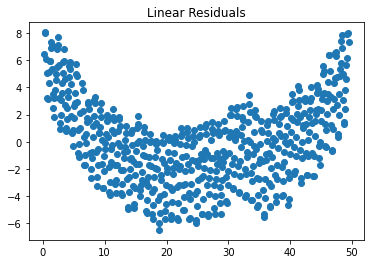

In [11]:
#Plot the residuals
plt.title("Linear Residuals")
plt.scatter(X_train, Y_train_residuals)

In [12]:
#Now predict values for the test set
Y_test_predict = reg.predict(X_test)

#Calculate the root means squared error and the mean absolute pct error 
RMSE = mean_squared_error(Y_test, Y_test_predict, squared=False)
MAPE = mean_absolute_percentage_error(Y_test, Y_test_predict)
print("RMSE: ", RMSE, " MAPE: ", MAPE)

RMSE:  10.642011413148976  MAPE:  0.024505275995447513


In [13]:
#Given the shape of the residuals and the poor RMSE and MAPE results from the linear model, lets try a quadratic model
#PolynomialFeatures and the make_pipeline should help simplify the process
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [14]:
#Start with a quadratic model (2nd order) and then fit it 
degree=2
quadreg=PolynomialFeatures(degree)
X_train_quad = quadreg.fit_transform(X_train)

linreg = LinearRegression()
linreg.fit(X_train_quad, Y_train)

Y_quad_predict = linreg.predict(X_train_quad)

#Print our fitted quadratic coefficients and intercept
print("Coefs: ", linreg.coef_, " Intercept: ", linreg.intercept_)

Coefs:  [[0.         0.80213511 0.01211779]]  Intercept:  [314.10295065]


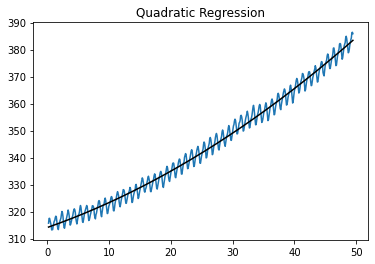

In [15]:
#Let's plot the fitted quadratic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_quad_predict,color="black")
plt.title("Quadratic Regression")
plt.show()

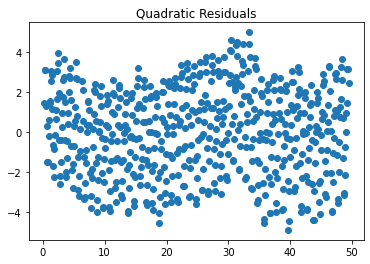

In [16]:
#Now lets calculate and look at the residuals for the quadratic model
quad_train_residuals = Y_train - Y_quad_predict
plt.title("Quadratic Residuals")
plt.scatter(X_train, quad_train_residuals)

In [17]:
#Now predict quadratic values for the transformed test set
X_test_quad = quadreg.transform(X_test)
Y_test_quad_predict = linreg.predict(X_test_quad)

#Calculate our coefficients, the RMSE and MASE
Quad_RMSE = mean_squared_error(Y_test, Y_test_quad_predict, squared=False)
Quad_MAPE = mean_absolute_percentage_error(Y_test, Y_test_quad_predict)
print("Quadratic RMSE: ", Quad_RMSE, " Quadratic MAPE: ", Quad_MAPE)

Quadratic RMSE:  2.5028073719222728  Quadratic MAPE:  0.005322789167375787


In [18]:
#Next try a cubic model (2nd order) and then fit it 
degree = 3
cubereg = PolynomialFeatures(degree)
X_train_cube = cubereg.fit_transform(X_train)

linreg2 = LinearRegression()
linreg2.fit(X_train_cube, Y_train)

Y_cube_predict = linreg2.predict(X_train_cube)

#Print our cubic fitted coefficients and intercept:
print("Coefs: ", linreg2.coef_, " Intercept: ", linreg2.intercept_)

Coefs:  [[ 0.00000000e+00  6.24869938e-01  2.09624454e-02 -1.18397534e-04]]  Intercept:  [314.86089144]


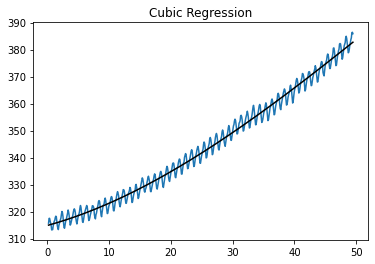

In [19]:
#Let's plot the fitted cubic model
plt.figure()
plt.plot(X_train,Y_train)
plt.plot(X_train,Y_cube_predict,color="black")
plt.title("Cubic Regression")
plt.show()

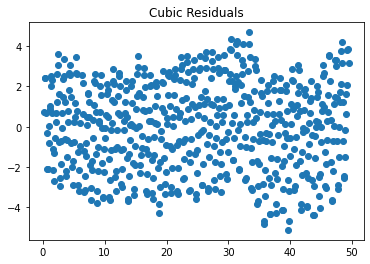

In [20]:
#Now lets calculate and look at the residuals for the quadratic model
cube_train_residuals = Y_train - Y_cube_predict
plt.title("Cubic Residuals")
plt.scatter(X_train, cube_train_residuals)

In [21]:
#Now predict quadratic values for the transformed test set
X_test_cube = cubereg.transform(X_test)
Y_test_cube_predict = linreg2.predict(X_test_cube)

#Calculate our coefficients, the RMSE and MASE
Cube_RMSE = mean_squared_error(Y_test, Y_test_cube_predict, squared=False)
Cube_MAPE = mean_absolute_percentage_error(Y_test, Y_test_cube_predict)
print("Cubic RMSE: ", Cube_RMSE, " Cubic MAPE: ", Cube_MAPE)

Cubic RMSE:  4.151525341775371  Cubic MAPE:  0.00848734285315907


In [73]:

#To assess seasonality, we average the residuals for each monthly period
JanIdx = np.where(co2_df['Month'][:train_count]==1)[0]
FebIdx = np.where(co2_df['Month'][:train_count]==2)[0]

JanAvgRes = np.mean(quad_train_residuals[JanIdx])
FebAvgRes = np.mean(quad_train_residuals[FebIdx])

print('January average residual:', JanAvgRes, 'February average residual:', FebAvgRes)

#quad_train_residuals


January average residual: -0.01564690643915142 February average residual: 0.6414997031065065
